>[Required Imports](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=Uba219r7Ksdn)

>[Utilites](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=CFv-GDQhKvLt)

>[Image Restoration](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=-kwszDiiLZ1A)

>[Noise](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=rqma09x4aY6C)

>[Superpixels & Segementation](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=KKkjyg8x38aS)

>>[Types](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=OXWHKis944Qf)

>>[Unsupervised Segementation](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=0CnC-dU34-4m)

>>>[A. Simple Linear Iterative Clustering SLIC based on k-means](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=H-PHL0tf5HcL)

>[Contours](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=BffUpYKk7edZ)

>[Canny Edge detector](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=nQmrxSltC5LH)

>[Corner Detection Harris Corner Detector](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=yyC6xB34FYhJ)

>[Face Detection](#updateTitle=true&folderId=1mBtWVlPv4v0vCYubpb3eo-hGxQlCbsdJ&scrollTo=zPWnp2MAJZu4)



In [92]:
# ! pip install scikit-image

# Required Imports

In [3]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage.filters import try_all_threshold,threshold_otsu,threshold_local,sobel,gaussian
import cv2
from cv2 import filter2D
from skimage.transform import rotate,rescale,resize
from skimage import morphology
from skimage import color
%matplotlib inline

# Utilites


In [4]:
def plot_image(image,title,cmap_ ='gray'):
  plt.imshow(image,cmap =cmap_)
  plt.axis('off')
  plt.title(title)
  plt.show()

def plot_histogram_channels(image):
  red_channel = image[:,:,0]
  green_channel = image[:,:,1]
  blue_channel = image[:,:,2]

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
  axs[0, 0].imshow(image)
  axs[0, 0].set_title('original')

  axs[0, 1].hist(red_channel.ravel(), bins=300,color='r')
  axs[0, 1].set_title('red-histogram')

  axs[1, 0].hist(green_channel.ravel(), bins=300,color='g')
  axs[1, 0].set_title('green-histogram')

  axs[1, 1].hist(blue_channel.ravel(), bins=300,color='b')
  axs[1, 1].set_title('blue-histogram')

  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  plt.show()

def plot_image_with_thresh(image,thresh):

  applied = image > thresh
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
  axs[0, 0].imshow(image,cmap ='gray')
  axs[0, 0].set_title('original')

  axs[0, 1].hist(image.ravel(),bins=300)
  axs[0, 1].set_title('original-histogram-cutting-threshold')
  if isinstance(thresh,int) and thresh:
    axs[0, 1].axvline(x=thresh, color='red')

    # Get the y-axis limits
    ymin, ymax = axs[0, 1].get_ylim()
    axs[0, 1].text(0.05, ymax*0.9, f'x={thresh}', color='r')

  axs[1, 0].imshow(applied,cmap ='gray')
  axs[1, 0].set_title('image after threshold')

  # axs[1, 1].hist(applied.ravel(), bins=300)
  # axs[1, 1].set_title('histogram after cutting')

  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  plt.show()

def plot_comparison(original, filtered, title_filtered):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True,  sharey=True)
  ax1.imshow(original, cmap=plt.cm.gray)
  ax1.set_title('original')
  ax1.axis('off')
  ax2.imshow(filtered, cmap=plt.cm.gray)
  ax2.set_title(title_filtered)
  ax2.axis('off')
  plt.show()

def plot_image_with_hist_equalization(image,after):

  applied = after
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
  axs[0, 0].imshow(image,cmap ='gray')
  axs[0, 0].set_title('original')

  axs[0, 1].hist(image.ravel(),bins=300)
  axs[0, 1].set_title('original-histogram')

  axs[1, 0].imshow(applied,cmap ='gray')
  axs[1, 0].set_title('image after equalization')

  axs[1, 1].hist(applied.ravel(), bins=300)
  axs[1, 1].set_title('histogram after equalization')

  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  plt.show()

# Image Restoration


In [5]:
image_orig = data.astronaut()

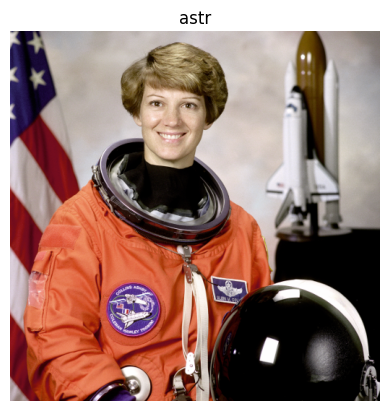

In [6]:
plot_image(image_orig,'astr')

In [7]:
from skimage.morphology import disk, binary_dilation
# Create mask with six block defect regions
mask = np.zeros(image_orig.shape[:-1], dtype=bool)
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1

# add randomly positioned small point-like defects
rstate = np.random.default_rng(0)
for radius in [0, 2, 4]:
    # larger defects are less common
    thresh = 3 + 0.25 * radius  # make larger defects less common
    tmp_mask = rstate.standard_normal(image_orig.shape[:-1]) > thresh
    if radius > 0:
        tmp_mask = binary_dilation(tmp_mask, disk(radius, dtype=bool))
    mask[tmp_mask] = 1

# Apply defect mask to the image over the same region in each color channel
image_defect = image_orig * ~mask[..., np.newaxis]

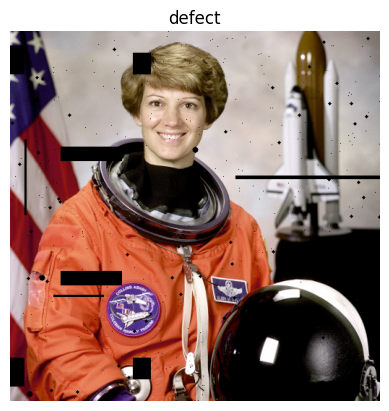

In [8]:
plot_image(image_defect,'defect')

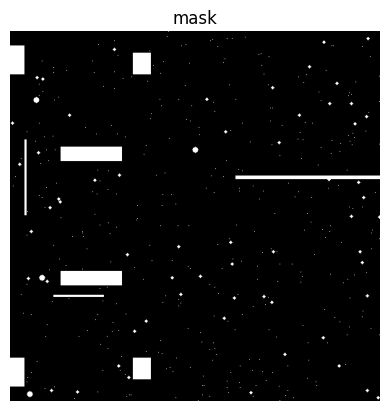

In [9]:
plot_image(mask,'mask')

In [10]:
from skimage.restoration import inpaint

<ipython-input-11-397fe684e776>:1: FutureWarning: `multichannel` is a deprecated argument name for `inpaint_biharmonic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  restored_image= inpaint.inpaint_biharmonic(image_defect,


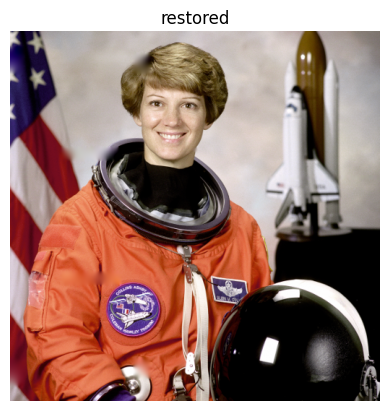

In [11]:
restored_image= inpaint.inpaint_biharmonic(image_defect,
                                           mask,
                                           multichannel=True)
plot_image(restored_image,'restored')

# Noise

In [12]:
from skimage.util import random_noise

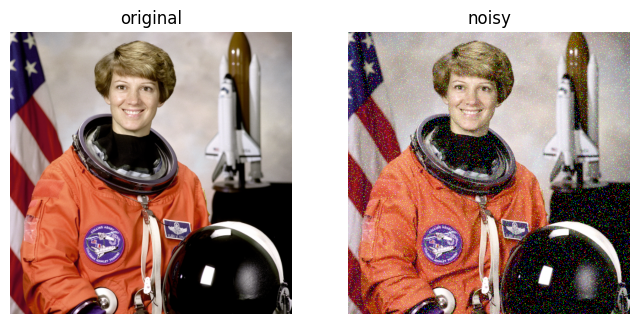

In [13]:
noisy_image = random_noise(image_orig,mode='salt')
plot_comparison(image_orig,noisy_image,'noisy')

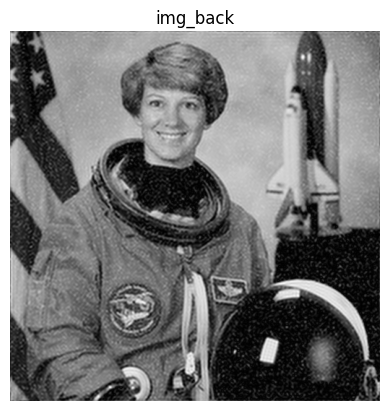

In [14]:
from scipy import ndimage
gray = color.rgb2gray(noisy_image)
f = np.fft.fft2(gray)

# Shift the zero-frequency component to the center of the spectrum
fshift = np.fft.fftshift(f)

# Apply a high-pass filter to remove low-frequency noise
cutoff_freq = 200
mask = ndimage.minimum_filter(fshift.real, cutoff_freq)
fshift *= mask

# Shift the zero-frequency component back to the corners of the spectrum
f_ishift = np.fft.ifftshift(fshift)

# Compute the inverse Fourier transform of the filtered spectrum
img_back = np.fft.ifft2(f_ishift)

# Convert the complex-valued result back to a real-valued image
img_back = np.abs(img_back)
plot_image(img_back,'img_back')

# Superpixels & Segementation

- superpixels:
group of connected pixels that have same intensity

## Types
1. Supervised
2. Unsupervised

## Unsupervised Segementation


### A. Simple Linear Iterative Clustering SLIC based on k-means


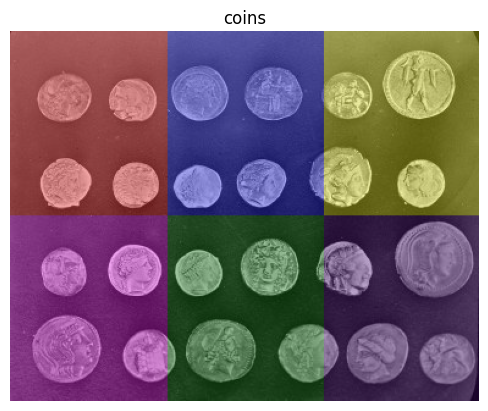

In [18]:
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage import data
coins  = data.coins()
segments = slic(coins,n_segments=6)
segmented_img = label2rgb(segments,coins)
plot_image(segmented_img,'coins')

# Contours

In [21]:
from skimage.measure import find_contours
# from measure import find_contours

In [33]:
# we have to pass to the contour function a binary image

# given image convert it to gray
gray = coins
#then do image segmentation using threshold approach for ex.
# to get the binarized image
thresh = threshold_otsu(gray)
# binary image
bin_image  = gray > thresh

contours = find_contours(bin_image,0.8)

# print(contours)

In [32]:
# project the contours into the image
# for con in contours:
#   print(con.shape)

In [34]:
from skimage import io, draw
import copy
# Create a blank mask the same shape as the image
image = copy.deepcopy(gray)
mask = np.zeros_like(image, dtype=np.bool)

# Draw polygons for each contour on the mask
for contour in contours:
    rr, cc = draw.polygon(contour[:, 0], contour[:, 1])
    mask[rr, cc] = True

# Assign the mask values to the original image
image[mask] = 255

<ipython-input-34-e91622f4ad73>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(image, dtype=np.bool)


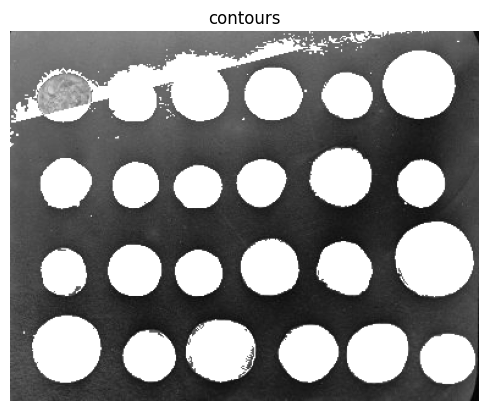

In [35]:
plot_image(image,'contours')

# Canny Edge detector
1. Filter image with x, y derivatives of Gaussian
2. Find magnitude and orientation of gradient
3. Non-maximum suppression:
– Thin multi-pixel wide “ridges” down to single pixel
width

4. Thresholding and linking (hysteresis):
– Define two thresholds: low and high
– Use the high threshold to start edge curves and the
low threshold to continue them

In [36]:
from skimage.feature import canny

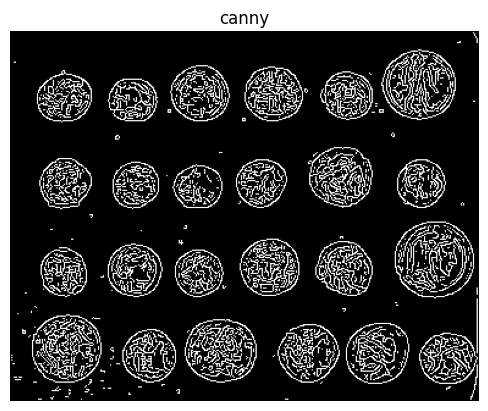

In [51]:
image = data.coins()
# gray_img = color.rgb2gray(image)

canny_img = canny(image,sigma=0.5,low_threshold = 50,high_threshold=60)
plot_image(canny_img,'canny')

# Corner Detection Harris Corner Detector

In [62]:
def show_image_with_corners(image, coords, title="Corners detected"):
  plt.imshow(image, interpolation='nearest', cmap='gray')
  plt.title(title)
  plt.plot(coords[:, 1], coords[:, 0],'+r', markersize=15)
  plt.axis('off')
  plt.show()

In [61]:
from skimage.feature import corner_harris,corner_peaks

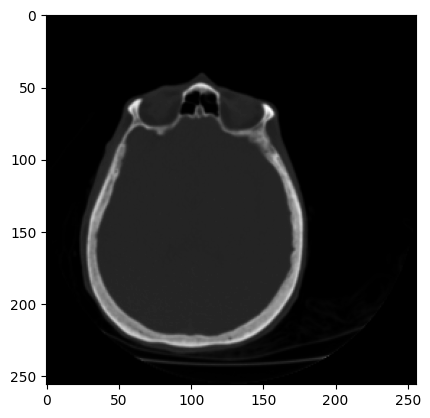

In [60]:
image = data.brain()
plt.imshow(image[0,:,:],cmap='gray')

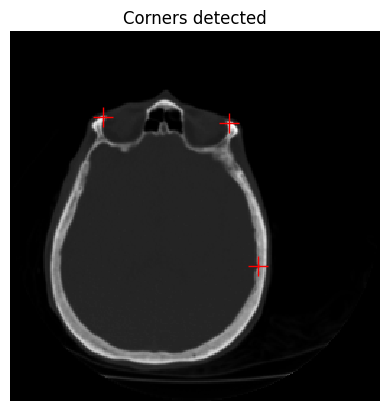

In [70]:
corners = corner_harris(image[0,:,:])
coord   = corner_peaks(corners,min_distance=50)
show_image_with_corners(image[0,:,:],coord)

# Face Detection

In [82]:
import matplotlib.patches as patches
def show_detected_face(result, detected, title="Face image"):
  plt.imshow(result)
  img_desc = plt.gca()
  plt.set_cmap('gray')
  plt.title(title)
  plt.axis('off')
  for patch in detected:
    img_desc.add_patch(
        patches.Rectangle(
          (patch['c'], patch['r']),
          patch['width'],
          patch['height'],
          fill=False,color='r'
          ,linewidth=2)
    )
    plt.show()


In [71]:
from skimage.feature import Cascade

In [72]:
trained_file = data.lbp_frontal_face_cascade_filename()

detector = Cascade(trained_file)

In [73]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


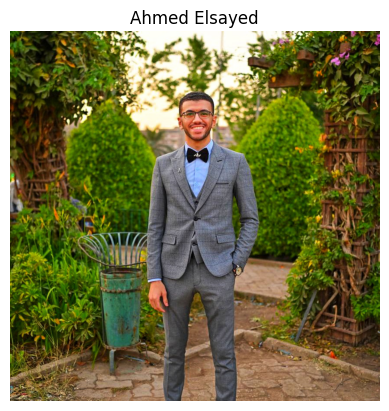

In [75]:
my_image = plt.imread('/content/drive/MyDrive/me.jpeg')
plot_image(my_image,'Ahmed Elsayed')

In [84]:
my_image.shape

(852, 852, 3)

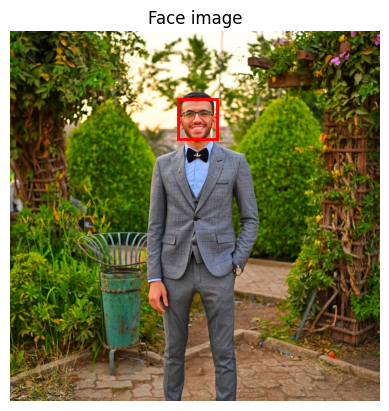

In [91]:
from matplotlib.scale import scale_factory
detected_face = detector.detect_multi_scale(img=my_image,
                                            scale_factor=1.2,
                                            step_ratio=1,
                                            min_size=(30,30),
                                            max_size=(200,200))
show_detected_face(my_image,detected_face)